#  TD-TME03 Perceptron

IA & Data science (LU3IN0226) -- 2020-2021
--------
*&copy; Equipe pédagogique: Vincent Guigue, Christophe Marsala, Edoardo Sarti, Olivier Schwander.*


<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

*Double-cliquer ici et insérer les noms et prénoms de votre binôme*
MISTRY Manish
TROUVE Alex

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-03</tt> et rajouter à la suite de <tt>tme-03</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *tme-03-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu est à remettre sur la page Moodle selon les directives données en séances.


Les imports suivants seront généralement nécessaires:

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  

## Retour sur le sujet du TME 2

In [2]:
# ------------------------ REPRENDRE ICI LES FONCTIONS DU TME 2:
# genere_dataset_uniform:
def genere_dataset_uniform(p,n,inf,sup):
    divison_pts=n//2
    desc=np.random.uniform(inf,sup,(n,p))
    lab=np.asarray([-1 for i in range (0, division_pts)] + [+1 for i in range (0,division_pts)])
    return (desc,lab)

# genere_dataset_gaussian:
def genere_dataset_gaussian(positive_center, positive_sigma, negative_center, negative_sigma, nb_points):
    pos=np.random.multivariate_normal(positive_center, positive_sigma, nb_points)
    neg=np.random.multivariate_normal(negative_center, negative_sigma, nb_points)
    res=np.vstack((neg,pos)),np.asarray([-1 for i in range(nb_points)] + [+1 for i in range(nb_points)])
    return res

In [3]:
# Exemple d'utilisation:
np.random.seed(42)   # on prend 42 comme graine

d_desc_gauss, d_lab_gauss = genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-0.5,-1]),np.array([[1,0],[0,1]]),20)

print("Taille du dataset généré :", np.shape(d_desc_gauss), "exemples")

d_desc_gauss[0:5,:]

Taille du dataset généré : (40, 2) exemples


array([[ 0.23846658, -0.82863172],
       [-0.61564828, -1.3011037 ],
       [-1.97852199, -1.71984421],
       [-0.96063877,  0.05712223],
       [-0.15638171, -2.76304016]])

### Couleurs des tracés

In [4]:
# Remarque : le nom des couleur est standardisé, pour connaître des noms de couleur possible:
import matplotlib as mpl

# ---------------> Décommenter la ligne suivante :
#mpl.colors.cnames

# utiliser internet pour visualiser ces couleurs...

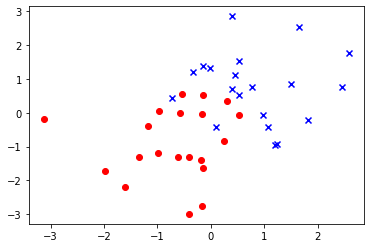

In [5]:
# Extraction des exemples de classe -1:
data_negatifs = d_desc_gauss[d_lab_gauss == -1]
# Extraction des exemples de classe +1:
data_positifs = d_desc_gauss[d_lab_gauss == +1]

# Affichage de l'ensemble des exemples :
plt.scatter(data_negatifs[:,0],data_negatifs[:,1],marker='o', color='red') # 'o' rouge pour la classe -1
plt.scatter(data_positifs[:,0],data_positifs[:,1],marker='x', color='blue') # 'x' bleu pour la classe +1

In [11]:
# ------------------------ REPRENDRE LA FONCTION plot2DSet :
# Modifier la fonction pour pouvoir utiliser la couleur 'red' pour la classe -1 et 'blue' pour la +1
def plot2DSet(desc,label):
    # Extraction des exemples de classe -1:
    data_negatifs = desc[label == -1]
    # Extraction des exemples de classe +1:
    data_positifs = desc[label == +1]
    plt.scatter(data_negatifs[:,0],data_negatifs[:,1],marker='o', color='red') # 'o' pour la classe -1
    plt.scatter(data_positifs[:,0],data_positifs[:,1],marker='x', color='blue') # 'x' pour la classe +1


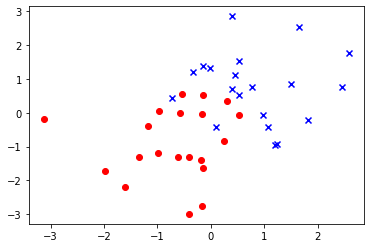

In [12]:
# Affichage :
plot2DSet(d_desc_gauss,d_lab_gauss)

### Nouvelle version de la fonction plot_frontiere
Cette nouvelle version gère un peu mieux les couleurs d'affichage

In [13]:
def plot_frontiere(desc_set, label_set, classifier, step=30):
    """ desc_set * label_set * Classifier * int -> NoneType
        Remarque: le 4e argument est optionnel et donne la "résolution" du tracé
        affiche la frontière de décision associée au classifieur
    """
    mmax=desc_set.max(0)
    mmin=desc_set.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    # colors[0] est la couleur des -1 et colors[1] est la couleur des +1
    plt.contourf(x1grid,x2grid,res,colors=["darksalmon","skyblue"],levels=[-1000,0,1000])

## Perceptron de Rosenblatt

De la même façon que nous avons défini un classifieur aléatoire et un classifieur par k-ppv, nous allons maintenant définir le classifieur qui a été présenté dans le cours 3 : le perceptron de Rosenblatt.
Il est fortement conseillé d'aller voir les transparents de ce cours 3 pour s'aider à implementer cet algorithme.


**Apprentissage:**<BR>
En termes d'entrées/sorties: l'apprentissage consiste à fournir une base de données étiquetées $X \in \mathbb R^{n\times d},Y\in \{-1,1\}^n$ et à récupérer un vecteur de paramètres optimisés $\mathbf w\in \mathbb R^{d}$.

En termes algorithmiques, l'apprentissage est itératif:
1. Initialisation de $\mathbf w$ soit à 0, soit aléatoirement. Attention, si l'initialisation est aléatoire, les valeurs doivent être très petites et également réparties entre valeurs positives et négatives pour ne pas biaiser l'algorithme.
1. Optimisation stochastique
    1. Tirage aléatoire d'un point $\mathbf x_i$
    1. Evaluation de l'erreur sur $\mathbf x_i, y_i$ avec le vecteur $\mathbf w$ courant
        1. Si *Pas d'erreur*, pas de correction
        1. Si *Erreur*, correction (petite) de la forme: 
        $$\mathbf w \leftarrow \mathbf w + \epsilon y_i \mathbf x_i$$
    1. Si convergence, sortir
        1. Convergence = plus ou peu de changements sur $\mathbf w$ pendant $n$ itérations. 
        1. Mettre un critère en nombre d'itérations pour ne pas se coincer dans une boucle infinie.

**Inférence:**<BR>
L'inférence est linaire: 
    $$\hat y_i =  \mathbf x_i \cdot \leftarrow w \in \mathbb R, \qquad \hat y_i^* =\mbox{sign}(\hat y_i) \in \{-1,1\}$$
   
   Attention à ne pas confondre l'évaluation linéaire à valeur réelle et le signe qui permet de mettre notre estimation dans le même univers que les étiquettes d'origine.

<font color="RED" size="+1">**[Q]**</font> En héritant de la classe `Classifier` (qu'il faut donc récupérer/ré-écrire pour la mettre dans ce notebook), écrire la classe `ClassifierPerceptron` qui implémente l'algorithme du perceptron de Rosenblatt vu en cours. 

Lors de l'initialisation, dans la méthode `__init__`, un learning_rate (aussi noté <i>epsilon</i>) pour le perceptron doit être fourni. L'initialisation du perceptron est faite en initialisant aléatoirement les valeurs de ses poids $w_1, \ldots, w_d$ dans $[-1,1]$.

La fonction `train` d'un perceptron doit réaliser **une itération** sur l'ensemble des données d'apprentissage en prenant les exemples dans un ordre aléatoire choisi au moment de l'exécution de la fonction `train`. Pour chaque exemple d'apprentissage $x$, on détermine le score donné par le perceptron et avec ce score on corrige les valeurs des poids du perceptron. Cette correction dépend de $x$ et de l'écart entre le score et la vraie classe de $x$, elle est pondérée par le learning rate du perceptron. 



In [14]:
# ------------------------ A COMPLETER :

# Recopier ici la classe Classifier (complète) du TME 2
# ------------------------ A COMPLETER :
class Classifier:
    """ Classe pour représenter un classifieur
        Attention: cette classe est une classe abstraite, elle ne peut pas être
        instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
            Hypothèse : input_dimension > 0
        """
        raise NotImplementedError("Please Implement this method")
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        raise NotImplementedError("Please Implement this method")
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")

    def accuracy(self, desc_set, label_set):
        """ Permet de calculer la qualité du système sur un dataset donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        # COMPLETER CETTE FONCTION ICI : 
        # ............
        # ............
        cpt=0
        taille_data = label_set.size
        for i in range(taille_data):
            if(self.predict(desc_set[i])==label_set[i]):
                cpt=cpt+1
        return (cpt/taille_data) * 100
        #raise NotImplementedError("Cette méthode doit être implémentée dans Classifier")

In [15]:
# ------------------------ A COMPLETER :

class ClassifierPerceptron(Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self, input_dimension,learning_rate):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples
                - learning_rate : epsilon
            Hypothèse : input_dimension > 0
        """
        self.weights = np.random.normal(0, 0.5, input_dimension)
        #self.weights = np.zeros(input_dimension)
        self.learning_rate = learning_rate
        #raise NotImplementedError("Please Implement this method")
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            réalise une itération sur l'ensemble des données prises aléatoirement
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """    
        ordre = np.arange(len(label_set))
        np.random.shuffle(ordre)
        
        for i in ordre:
            if self.predict(desc_set[i]) * label_set[i] < 0:
                self.weights += self.learning_rate * desc_set[i] * label_set[i] 
        #raise NotImplementedError("Please Implement this method")
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        return np.dot(x, self.weights)
        #raise NotImplementedError("Please Implement this method")
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        return 1 if self.score(x) > 0 else -1
        #raise NotImplementedError("Please Implement this method")

    

## Validation de l'algorithme

<font color="RED" size="+1">**[Q]**</font>  Afin de vérifier le bon fonctionnement de l'algorithme, nous allons procéder à une série de test:

1. Test sur les gaussiennes jouets de la semaine 2
    1. Vérifier l'impact du réglage de l'initialisation (normalement, il n'y a pas trop d'impact sur un problème aussi simple)
    1. Vérifier l'impact du réglage de epsilon (impact énorme: ca diverge très rapidement!!)
    1. En jouant sur la génération des données, tester votre perceptron dans le cas facile (nuages des deux classes bien séparés) puis dans le cas plus difficile où les classes ne sont plus séparables linéairement.

1. Test sur les données USPS (cf. TME 2)
    1. Nous travaillerons uniquement dans le cas binaire. Prendre les 1 vs 2 (cas facile) puis les 3 vs 6 ou 9 (cas nettement plus dur)
    
1. Penser à faire le parallèle avec le temps d'inférence sur les k-ppv de la semaine précédente
    
**Note:** il faut évidemment multiplier les boites et ne pas tout faire au même endroit.

# 1.Test sur les gaussiennes 
    #B. Vérification de l'impact du réglage de l'epsilon

87.5


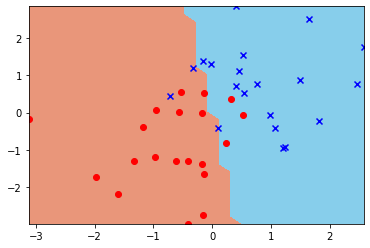

In [57]:
learning_rate = 10e-1
perceptron = ClassifierPerceptron(d_desc_gauss[0].shape[0], learning_rate)

N = 50

for i in range(N):
    perceptron.train(d_desc_gauss, d_lab_gauss)
    #print(perceptron.accuracy(d_desc_gauss, d_lab_gauss))
    
# Affichage de la frontière de séparation des classes
print(perceptron.accuracy(d_desc_gauss, d_lab_gauss))
plot_frontiere(d_desc_gauss,d_lab_gauss,perceptron)
plot2DSet(d_desc_gauss,d_lab_gauss)

Taux de bonne classification sur le dataset:  91.0
Taux de bonne classification sur le dataset:  92.0
Taux de bonne classification sur le dataset:  92.0
Taux de bonne classification sur le dataset:  93.0
Taux de bonne classification sur le dataset:  95.0
Taux de bonne classification sur le dataset:  95.0
Taux de bonne classification sur le dataset:  91.0
Taux de bonne classification sur le dataset:  92.0
Taux de bonne classification sur le dataset:  95.0
Taux de bonne classification sur le dataset:  92.0


Text(0.5, 1.0, 'epsilon 10^-2')

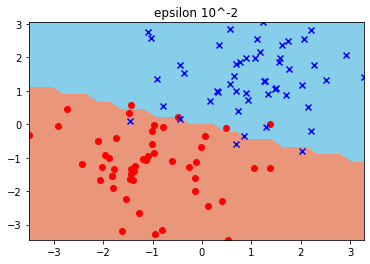

In [17]:
epsilon=pow(10,-2)
perceptron = ClassifierPerceptron(2,epsilon)

data_desc, data_label = genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),50)

perceptron.train(data_desc, data_label)

#Affichage du taux de bonne classification
N = 10
for i in range(N):
    perceptron.train(data_desc, data_label)
    print("Taux de bonne classification sur le dataset: ", perceptron.accuracy(data_desc, data_label))

plot_frontiere(data_desc, data_label, perceptron)
plot2DSet(data_desc, data_label)
plt.title("epsilon 10^-2")

Taux de bonne classification sur le dataset:  90.0


Text(0.5, 1.0, 'epsilon 10^-3')

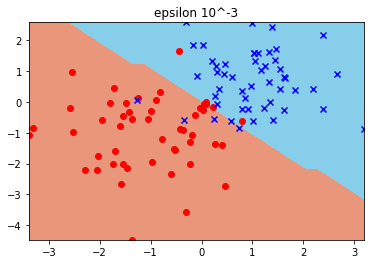

In [22]:
epsilon=pow(10,-3)
perceptron = ClassifierPerceptron(2,epsilon)

data_desc, data_label = genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),50)

perceptron.train(data_desc, data_label)

#Affichage du taux de bonne classification
print("Taux de bonne classification sur le dataset: ", perceptron.accuracy(data_desc, data_label))

plot_frontiere(data_desc, data_label, perceptron)
plot2DSet(data_desc, data_label)
plt.title("epsilon 10^-3")

Taux de bonne classification sur le dataset:  38.0


Text(0.5, 1.0, 'epsilon 10^-5')

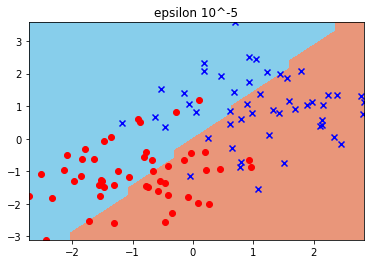

In [58]:
epsilon=pow(10,-5)
perceptron = ClassifierPerceptron(2,epsilon)

data_desc, data_label = genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),50)

perceptron.train(data_desc, data_label)

#Affichage du taux de bonne classification
print("Taux de bonne classification sur le dataset: ", perceptron.accuracy(data_desc, data_label))

plot_frontiere(data_desc, data_label, perceptron)
plot2DSet(data_desc, data_label)
plt.title("epsilon 10^-5")

    # 1.C.Donnée linéaire

Taux de bonne classification sur le dataset:  88.0


Text(0.5, 1.0, 'epsilon 10^-3')

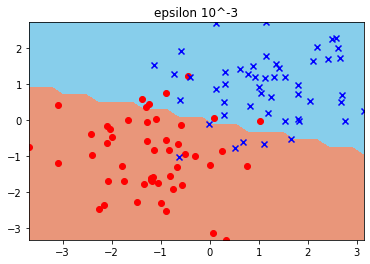

In [23]:
epsilon=pow(10,-3)
perceptron = ClassifierPerceptron(2,epsilon)

data_desc, data_label = genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),50)

perceptron.train(data_desc, data_label)

#Affichage du taux de bonne classification
print("Taux de bonne classification sur le dataset: ", perceptron.accuracy(data_desc, data_label))

plot_frontiere(data_desc, data_label, perceptron)
plot2DSet(data_desc, data_label)
plt.title("epsilon 10^-3")

Taux de bonne classification sur le dataset:  98.0


Text(0.5, 1.0, 'epsilon 10^-3')

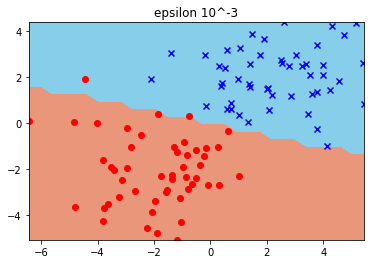

In [34]:
epsilon=pow(10,-3)
perceptron = ClassifierPerceptron(2,epsilon)

data_desc, data_label = genere_dataset_gaussian(np.array([2,2]),np.array([[2,0],[0,2]]),np.array([-2,-2]),np.array([[2,0],[0,2]]),50)

perceptron.train(data_desc, data_label)

#Affichage du taux de bonne classification
print("Taux de bonne classification sur le dataset: ", perceptron.accuracy(data_desc, data_label))

plot_frontiere(data_desc, data_label, perceptron)
plot2DSet(data_desc, data_label)
plt.title("epsilon 10^-3")

# 2.Test sur les données USPS
    A.Le cas binaire

## Sur-apprentissage

Comme expliqué en cours, le sur-apprentissage consiste à apprendre une règle:
1. Parfaite sur les données d'apprentissage
1. Absurde ou inutile sur les données *en général*

Votre but de data-scientist est d'éviter ce piège. Il existe de nombreuses stratégies pour faire face à ce défi majeur... Mais la première chose à faire est de savoir détecter le problème.

<img src="ressources/overfitting.png" > <BR>
<center>FIG: la proposition de droite est parfaite sur les données observées en apprentissage... Mais absurde en général
</center>

<font color="RED" size="+1">**[Q]**</font>   Pour ce faire, nous allons toujours évaluer nos algorithmes sur des données *neutres*, c'est à dire sur des données n'ayant pas servi à l'apprentissage.

1. Dans le cas de données jouets générées: tirer un second jeu de données avec les mêmes paramètres
1. Dans le cas USPS (toujours en 2 classes), récupérer les données de test et évaluer votre modèle dessus

Comparer les performances en apprentissage (c'est-à dire sur le dataset qui a servi à construire entraîner le modèle) et en test (c'est-à-dire sur un dataset différent du dataset d'apprentissage).


In [35]:
from sklearn.model_selection import train_test_split
def generate_train_test(total, percentage_test):
    assert(isinstance(percentage_test, float) and percentage_test > 0 and percentage_test < 1)
    data, labels = genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]), total)
    
    return train_test_split(data, labels, test_size=percentage_test, random_state=42)

train_data, test_data, train_label, test_label = generate_train_test(100, 0.3)

83.33333333333334
83.33333333333334


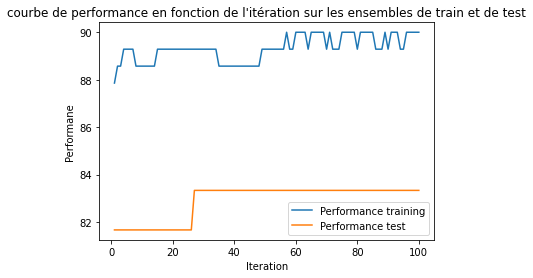

In [36]:
N = 100
iterations = np.asarray([i for i in range(1, N+1)])
perf_train = []
perf_test = []
best_perceptron = ClassifierPerceptron(d_desc_gauss[0].shape[0], learning_rate)

for i in range(N):
    test_acc = perceptron.accuracy(test_data, test_label)
    if test_acc > best_perceptron.accuracy(test_data, test_label):
        best_perceptron.weights = perceptron.weights
        
    perceptron.train(train_data, train_label)
    perf_train.append(perceptron.accuracy(train_data, train_label))       
    perf_test.append(perceptron.accuracy(test_data, test_label))

plt.plot(iterations, perf_train, label='Performance training')
plt.plot(iterations, perf_test, label='Performance test')
plt.ylabel('Performane')
plt.xlabel('Iteration')
plt.title("courbe de performance en fonction de l'itération sur les ensembles de train et de test")
plt.legend()

print(perceptron.accuracy(test_data, test_label))
print(best_perceptron.accuracy(test_data, test_label))

<font color="RED" size="+1">[Q]</font> Afin de tester des cas plus difficiles (c'est-à-dire non séparables linéairement), écrire la fonction `createXOR` qui permet de générer le jeu de données ci-dessous. Cette fonction prend 2 arguments, un nombre de points $n$ et un réel positif $\sigma$ donnant la variance sur chaque dimension et permet de jouer sur la dispersion des nuages et donc sur la séparation des 4 nuages.

Il s'agit de générer des points dans deux classes mais selon 4 gaussiennes.

<img src="ressources/xor.png" width=300px>



In [50]:
def create_XOR(nb_points,var):
    x=np.zeros(2)
    a = genere_dataset_gaussian(np.array([0,1]), np.array([[var,0],[0,var]]),np.array([0,0]), np.array([[var,0],[0,var]]), nb_points)
    b = genere_dataset_gaussian(np.array([1,0]), np.array([[var,0],[0,var]]),np.array([1,1]), np.array([[var,0],[0,var]]), nb_points)
    
    d1,l1=a
    d2,l2=b
    
    x=np.vstack((d1,d2))
    y=np.concatenate((l1,l2), axis=None)
    l=[]
    l.append(x)
    l.append(y)
    return l

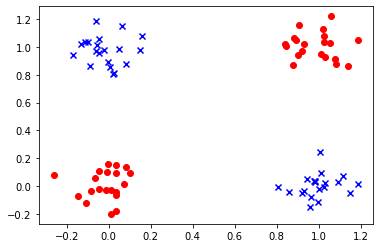

In [51]:
# une fois le fichier d'outils mis à jour, vous devez pouvoir faire:

np.random.seed(42)   # on prend 42 comme graine

# Génération d'un dataset avec 80 points:
data_xor, label_xor = create_XOR(20,0.01)
plot2DSet(data_xor, label_xor)

<font color="RED" size="+1">[Q]</font> Appliquer l'algorithme du perceptron sur ces données et constater (avec quelques affichages de performances et tracés de frontières de décision) que ça ne marche pas!

Taux de bonne classification sur le dataset:  36.875


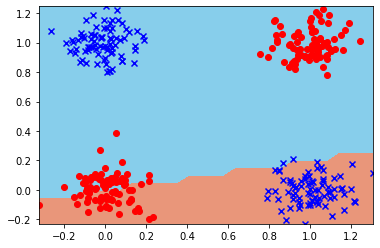

In [54]:
# Pour avoir les mêmes valeurs aléatoires :
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# ------------------------ A COMPLETER :
data_xor, label_xor = create_XOR(80,0.01)
plot2DSet(data_xor, label_xor)
epsilon=pow(10,-3)
perceptron = ClassifierPerceptron(2, epsilon)
print("Taux de bonne classification sur le dataset: ", perceptron.accuracy(data_xor, label_xor))
plot_frontiere(data_xor, label_xor, perceptron)
plot2DSet(data_xor, label_xor)

Kernel Trick
--------------

Les résultats précédents ne sont pas vraiment très bon, le perceptron n'arrive pas à séparer correctement les 2 classes... (expliquez pourquoi)

L'astuce du noyau ("kernel trick") est un moyen pour améliorer ses performances.

Un "kernel" est une "fonction noyau" (ou simplement "noyau") qui permet de représenter des données d'un espace donné dans un autre espace, souvent de dimension plus grande.

Comme vu en cours, l'idée est toute simple:
Soit une matrice 2D d'observations:
$$X =\left[
    \begin{array}{cc}
    x_{11} & x_{12}\\
    \vdots & \vdots \\
    x_{N1} & x_{N2}\\
    \end{array}
    \right]\in \mathbb R^{N\times 2}$$

La fonction $f(\mathbf x) = \mathbf w \cdot \mathbf x$ correspond à une frontière linéaire dans l'espace 2D... Qui passe par $(0,0)$.

Mais admettons que j'ajoute des colonnes dans $X$:
$$X^* =\left[
    \begin{array}{cccccc}
    x_{11} & x_{12} & x_{11}^2 & x_{12}^2 & x_{11} x_{12} & 1 \\
    \vdots & \ddots &&&&\vdots\\
    x_{N1} & x{N2} & x_{N1}^2 & x_{N2}^2 & x_{N1} x_{N2} & 1 \\
    \end{array}
    \right]\in \mathbb R^{N\times 6}$$

La fonction $f(\mathbf x^*) = \mathbf w \cdot \mathbf x^*$ correspond à une frontière linéaire dans l'espace 6D... Et une frontière non linéaire dans l'espace d'origine !



Le noyau est la fonction de transformation $$K: \mathbf x \rightarrow \mathbf x^*$$

**Note** Il faudra être très attentif, on fait tous les calculs avec des $\mathbf x^*$ mais on fait tous les affichages avec des $\mathbf x$...

In [41]:
class Kernel():
    """ Classe pour représenter des fonctions noyau
    """
    def __init__(self, dim_in, dim_out):
        """ Constructeur de Kernel
            Argument:
                - dim_in : dimension de l'espace de départ (entrée du noyau)
                - dim_out: dimension de l'espace de d'arrivée (sortie du noyau)
        """
        self.input_dim = dim_in
        self.output_dim = dim_out
        
    def get_input_dim(self):
        """ rend la dimension de l'espace de départ
        """
        return self.input_dim

    def get_output_dim(self):
        """ rend la dimension de l'espace d'arrivée
        """
        return self.output_dim
    
    def transform(self, V):
        """ ndarray -> ndarray
            fonction pour transformer V dans le nouvel espace de représentation
        """        
        raise NotImplementedError("Please Implement this method")
        

L'intérêt de définir une classe mère `Kernel` qui servira à définir des noyaux et que l'on pourra maintenant définir des algorithmes génériques qui pourront prendre des noyaux quelconques en argument.

### Un premier noyau

Le premier noyau, très simple, que l'on définit permet de projeter (manuellement) des données 2D dans un espace de plus grande dimension. 

Voici un exemple de projection qui transforme le vecteur $(x_1,x_2)$ en vecteur $(x_1,x_2,1)$

In [42]:
class KernelBias(Kernel):
    """ Classe pour un noyau simple 2D -> 3D
    """
    def transform(self, V):
        """ ndarray de dim 2 -> ndarray de dim 3            
            rajoute une 3e dimension au vecteur donné
        """
        V_proj = np.append(V,np.ones((len(V),1)),axis=1)
        return V_proj

In [43]:
# Exemple d'utilisation : 
kb = KernelBias(2,3)

data_xor_transf= kb.transform(data_xor)

print("data_xor:\n", data_xor[0:5,:])

print("\ndata_xor_transf:\n", data_xor_transf[0:5,:])

data_xor:
 [[-0.09746817  0.07870846]
 [ 0.11585956 -0.08206823]
 [ 0.09633761  0.04127809]
 [ 0.08220602  0.1896793 ]
 [-0.02453881 -0.07537362]]

data_xor_transf:
 [[-0.09746817  0.07870846  1.        ]
 [ 0.11585956 -0.08206823  1.        ]
 [ 0.09633761  0.04127809  1.        ]
 [ 0.08220602  0.1896793   1.        ]
 [-0.02453881 -0.07537362  1.        ]]


### Un noyau un peu plus compliqué

<font color="RED" size="+1">**[Q]**</font> Implémenter le kernel : $(x_1,x_2) \rightarrow (1,x_1,x_2,x_1*x_1,x_2*x_2,x_1*x_2)$. 

In [44]:
class KernelPoly(Kernel):
    def transform(self,V):
        """ ndarray de dim 2 -> ndarray de dim 6            
            ...
        """
        ##TODO
        #raise NotImplementedError("Please Implement this method")
        V_prog=np.asarray(([1,V[0],V[1],V[0]*V[0], V[1]*V[1], V[0]*V[1] ]))
        return V_prog


In [45]:
# Exemple d'utilisation : 
kp = KernelPoly(2,6)
kp.transform(data_xor[0,:])

array([ 1.        , -0.09746817,  0.07870846,  0.00950004,  0.00619502,
       -0.00767157])

<font color="RED" size="+1">**[Q]**</font> Implémenter la classe `ClassifierPerceptronKernel` qui prend un kernel en paramètre, et calcule le perceptron sur la version "kernélisée" des données. Tester ce perceptron sur le dataset 1 (2 gaussiennes) et le dataset XOR.

In [46]:
# ------------------------ A COMPLETER :
class ClassifierPerceptronKernel(Classifier):
    def __init__(self, input_dimension, learning_rate, noyau):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (espace originel)
                - learning_rate : 
                - noyau : Kernel à utiliser
            Hypothèse : input_dimension > 0
        """
        #raise NotImplementedError("Please Implement this method")
        self.epsilon=learning_rate
        self.phi=noyau
        self.w=np.zeros(input_dimension)
        
        
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        #raise NotImplementedError("Please Implement this method")
        x1=self.phi.transform(x)
        return np.dot(x1,self.w)
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        #raise NotImplementedError("Please Implement this method")
        res=self.score(x)
        if res<0:
            return -1
        else:
            return +1

    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        #raise NotImplementedError("Please Implement this method")
        ordre=np.arange(label_set.size)
        np.random.shuffle(ordre)
        for i in ordre:
            if label_set[i]*self.predict(desc_set[i,:])<0:
                self.w += self.epsilon*self.phi.transform(desc_set[i,:])*label_set[i]
                self.w /= np.linalg.norm(self.w)

<font color="RED" size="+1">**[Q]**</font> Entraîner un perceptron kernelisé utilisant un `KernelPoly` sur un dataset correspondant au XOR (cf. sujet du TME 2). Que constatez-vous ? Proposez une explication.

In [23]:

##TESTER SUR XOR ET DESSINER LA FRONTIèRE DE DECISION



In [47]:
# Pour avoir les mêmes valeurs aléatoires :
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# ------------------------ A COMPLETER :
N=100
epsilon=10^-1

perceptronKernel=ClassifierPerceptronKernel(3,epsilon,kp)
acc=np.zeros(N)
for i in range(N):
    perceptronKernel.train(data_xor[0], data_xor[1])
    acc[i]=perceptronKernel.accuracy(data_xor[0],data_xor[1])

ut.plot_frontiere(data_xor[0],data_xor[1],perceptronKernel)
ut.plot2DSet(data_xor[0],data_xor[1])
fig,ax=plt.subplot(figsize=(10,10))
ax.grid(True)
ax.set_xlabel("N")
ax.set_ylabel("Accuracy")
ax.plot(cpt,lable='Aprenstissage')

ax.legend(loc="upper right")
ax.set_title("Accuracy par rapport au nombre de N de tours d'apprentissage")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

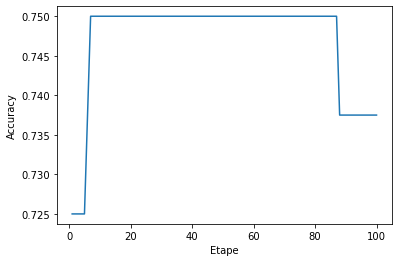

Accuracy finale :  0.7375


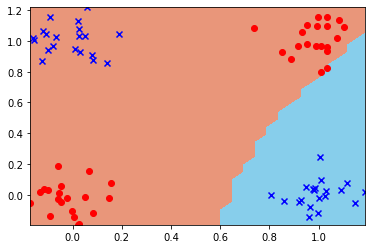

In [24]:
# Pour avoir les mêmes valeurs aléatoires :
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# ------------------------ A COMPLETER :




## Version multi-classes

Le perceptron est un algorithme fondamentalement bi-classes: il est même lié à la manière dont sont encodées les étiquettes $\{+1,-1\}$. La plupart des problèmes réels sont pourtant multi-classes (e.g. USPS).
Si cet algorithme a pu rester aussi classique, c'est qu'il existe une extension multi-classes simple et efficace: le *un-contre-tous*

<img src="ressources/multi2.png">

Il faut apprendre autant de classifieurs que de classes. 
Dans l'exemple ci-dessus, cela donne:

1. Traitement de la classe 0
    1. redéfinition de:
    $$Y_{tmp} = \left\{
\begin{array}{ll}
1 & \mbox{ si } Y == 0\\
-1 & \mbox{ si } Y == 1 || Y == 1\\
\end{array}\right.
$$
    1. apprentissage de $f_0$ sur $X,Y_{tmp}$
1. Traitement de la classe 1
    1. redéfinition de:
    $$Y_{tmp} = \left\{
\begin{array}{ll}
1 & \mbox{ si } Y == 1\\
-1 & \mbox{ si } Y == 0 || Y == 2\\
\end{array}\right.
$$
    1. apprentissage de $f_1$ sur $X,Y_{tmp}$
1. etc...


En inférence, lorsqu'un nouveau point $\mathbf x$ est présenté il faut:
1. calculer $score = [f_0(\mathbf x),  f_1(\mathbf x), \ldots f_C(\mathbf x)]$
1. prédire $\mbox{argmin}_c (score)$

<font color="RED" size="+1">**[Q]**</font> Construire une classe `Perceptron_MC` pour faire de la prédiction multi-classes et tester le code sur les données USPS.

## Mise en oeuvre sur des données réelles 
-------
A partir de datasets trouvés sur le web, réaliser un ensemble d'expérimentations permettant de comparer les 3 classifiers (knn, perceptron de Rosenblatt et version kernélisée) que vous avez implémentés.

Par exemple, vous pouvez utiliser les datasets suivants:
- https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra
- https://www.kaggle.com/uciml/indian-liver-patient-records
- voir sur les données ouvertes de Paris : https://opendata.paris.fr/explore/?sort=modified

Afin d'utiliser de tels jeux de données, il sera certainement nécessaire que vous réalisiez un prétraitement afin de pouvoir utiliser vos implémentations.